In [ ]:
!pip install flask-ngrok
!pip install -U flask-cors
!pip install hdfs
!pip install backtrader
from hdfs import *


     |████████████████████████████████| 410 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks') 

Mounted at /content/drive


In [ ]:
import pandas as pd
import base64
import time
import matplotlib.pyplot as plt
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import json
from flask_cors import CORS
import matplotlib.image as mpimg # mpimg 用于读取图片
app = Flask(__name__)
run_with_ngrok(app)
CORS(app)


df_stock_DOGE = pd.read_csv('DOGEUSDT_m7d16_500K.csv')
df_stock_BNB = pd.read_csv('BNBUSDT_m7d16_750K.csv')
df_stock_BTC = pd.read_csv('BTCUSDT_m7d16_900K.csv')
df_stock_ETH = pd.read_csv('ETHUSDT_m7d16_750K.csv')
df_stock_DOGE = df_stock_DOGE.drop(columns=['json_parse'])
df_stock_BNB = df_stock_BNB.drop(columns=['json_parse'])
df_stock_BTC = df_stock_BTC.drop(columns=['json_parse'])
df_stock_ETH = df_stock_ETH.drop(columns=['json_parse'])

### 以1天為間隔爬取的文件

In [ ]:
df_stock_DOGE_day = pd.read_csv('DOGEUSDT_t1d_757.csv')
df_stock_BNB_day = pd.read_csv('BNBUSDT_t1d_1363.csv')
df_stock_BTC_day = pd.read_csv('BTCUSDT_t1d_1444.csv')
df_stock_ETH_day = pd.read_csv('ETHUSDT_t1d_1444.csv')
print(df_stock_BNB_day.tail())

           openTime    open  ...  takerBuyQuoteAssetVolume  ignore
1358  1627257600000  302.56  ...              4.146522e+08     0.0
1359  1627344000000  304.00  ...              2.695125e+08     0.0
1360  1627430400000  313.47  ...              2.090210e+08     0.0
1361  1627516800000  313.84  ...              1.637382e+08     0.0
1362  1627603200000  317.10  ...              1.311318e+08     0.0

[5 rows x 12 columns]


### 整理資料集(以天計算)

In [ ]:
df_stock_BTC_day = df_stock_BTC_day.dropna()
df_stock_BNB_day = df_stock_BNB_day.dropna()
df_stock_ETH_day = df_stock_ETH_day.dropna()
df_stock_DOGE_day = df_stock_DOGE_day.dropna()

df_stock_BTC_day.index = range(len(df_stock_BTC_day))
df_stock_BNB_day.index = range(len(df_stock_BNB_day))
df_stock_ETH_day.index = range(len(df_stock_ETH_day))
df_stock_DOGE_day.index = range(len(df_stock_DOGE_day))

print(df_stock_BNB_day.head())
print(df_stock_BNB_day.tail())

        openTime    open  ...  takerBuyQuoteAssetVolume        ignore
0  1509926400000  1.5000  ...              76279.893180  1.022767e+08
1  1510012800000  1.5710  ...             130637.808431  1.023619e+08
2  1510099200000  1.7901  ...             362665.422644  1.025275e+08
3  1510185600000  1.9781  ...             303358.286789  1.026984e+08
4  1510272000000  1.9900  ...             313532.530513  1.028779e+08

[5 rows x 12 columns]
           openTime    open  ...  takerBuyQuoteAssetVolume  ignore
1358  1627257600000  302.56  ...              4.146522e+08     0.0
1359  1627344000000  304.00  ...              2.695125e+08     0.0
1360  1627430400000  313.47  ...              2.090210e+08     0.0
1361  1627516800000  313.84  ...              1.637382e+08     0.0
1362  1627603200000  317.10  ...              1.311318e+08     0.0

[5 rows x 12 columns]


In [ ]:
def MoveDownRSIandPrice(df_stock):
  #df_stock['rsi'] = df_stock['rsi'].shift(1)
  df_stock['last_close'] = df_stock['close'].shift(1)
  df_stock['last_open'] = df_stock['open'].shift(1)

  df_stock = df_stock.dropna()
  df_stock.index = range(len(df_stock))
  return df_stock

In [ ]:
df_stock_DOGE_day = MoveDownRSIandPrice(df_stock_DOGE_day)
df_stock_BNB_day = MoveDownRSIandPrice(df_stock_BNB_day)
df_stock_BTC_day = MoveDownRSIandPrice(df_stock_BTC_day)
df_stock_ETH_day = MoveDownRSIandPrice(df_stock_ETH_day)
print(df_stock_BTC_day)

           openTime      open      high  ...        ignore  last_close  last_open
0     1503014400000   4285.08   4371.52  ...   9384.141409     4285.08    4261.48
1     1503100800000   4108.37   4184.69  ...   9184.085529     4108.37    4285.08
2     1503187200000   4120.98   4211.08  ...  10125.414084     4139.98    4108.37
3     1503273600000   4069.13   4119.62  ...  11706.769970     4086.29    4120.98
4     1503360000000   4016.00   4104.82  ...  11773.279500     4016.00    4069.13
...             ...       ...       ...  ...           ...         ...        ...
1438  1627257600000  35381.02  40550.00  ...      0.000000    35381.02   34261.51
1439  1627344000000  37241.33  39542.61  ...      0.000000    37237.60   35381.02
1440  1627430400000  39456.61  40900.00  ...      0.000000    39457.87   37241.33
1441  1627516800000  40019.57  40640.00  ...      0.000000    40019.56   39456.61
1442  1627603200000  40018.49  40250.00  ...      0.000000    40016.48   40019.57

[1443 rows x 14

### 調整時間格式

In [ ]:
def timer(df_stock):
  for i in df_stock['openTime']:
    time_stamp = (int)((i)/1000) # 設定timeStamp
    struct_time = time.localtime(time_stamp) # 轉成時間元組
    timeString = time.strftime("%Y-%m-%d", struct_time) # 轉成字串
    timeString = pd.to_datetime(timeString)
    df_stock['openTime'] = df_stock['openTime'].replace(i, timeString)
    
  
  print(df_stock['openTime'].tail())
  return df_stock

In [ ]:
df_stock_BTC_day = timer(df_stock_BTC_day)
df_stock_BNB_day = timer(df_stock_BNB_day)
df_stock_ETH_day = timer(df_stock_ETH_day)
df_stock_DOGE_day = timer(df_stock_DOGE_day)

1438   2021-07-26
1439   2021-07-27
1440   2021-07-28
1441   2021-07-29
1442   2021-07-30
Name: openTime, dtype: datetime64[ns]
1357   2021-07-26
1358   2021-07-27
1359   2021-07-28
1360   2021-07-29
1361   2021-07-30
Name: openTime, dtype: datetime64[ns]
1438   2021-07-26
1439   2021-07-27
1440   2021-07-28
1441   2021-07-29
1442   2021-07-30
Name: openTime, dtype: datetime64[ns]
751   2021-07-26
752   2021-07-27
753   2021-07-28
754   2021-07-29
755   2021-07-30
Name: openTime, dtype: datetime64[ns]


In [ ]:
df_stock_BTC_day.rename(columns={'openTime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df_stock_BTC_day.set_index("Date", inplace=True)

df_stock_BNB_day.rename(columns={'openTime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df_stock_BNB_day.set_index("Date", inplace=True)

df_stock_ETH_day.rename(columns={'openTime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df_stock_ETH_day.set_index("Date", inplace=True)

df_stock_DOGE_day.rename(columns={'openTime': 'Date', 'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'}, inplace=True)
df_stock_DOGE_day.set_index("Date", inplace=True)

In [ ]:
print(df_stock_BTC_day.index[0])

2017-08-18 00:00:00


### RSI策略執行

In [ ]:
import backtrader as bt
import backtrader.feeds as btfeeds
import datetime


@app.route('/getRSI', methods=['POST'])
def getRSI():
  

  stock={'BTC':df_stock_BTC_day, 'BNB':df_stock_BNB_day, 'ETH':df_stock_ETH_day, 'DOGE':df_stock_DOGE_day}
  date = {3:datetime.datetime(2021,4,30), 6:datetime.datetime(2021,1,30), 12:datetime.datetime(2020,7,30), 24:datetime.datetime(2019,7,30)}
  rJson = request.json

  #request data
  coin = rJson['coin']
  time = rJson['time']
  upbound = rJson['upBound']
  downbound = rJson['downBound']
  starting_cash = rJson['starting_cash']
  commission = rJson['commission']

  df_stock = stock[coin]

  class RSIStrategy(bt.Strategy):
    #log function
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s: %s' % (dt.isoformat(), txt))

    #initialisation function
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        #declare a rsi variable
        self.rsi = bt.indicators.RSI(self.data, period = 14)
        #in position variable
        self.in_position = False
        self.upbound = upbound
        self.downbound = downbound
 

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return


        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
        
    def next(self):
        self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        #if the symbol is overbought
        if self.rsi[0] > self.upbound:
            #if in position is true, sell
            if self.in_position:
                self.log('SELL CREATE, %.2f' % self.dataclose[0])
                self.order = self.sell()
                self.in_position = False
            else:
                pass
        #if the symbol is oversold
        elif self.rsi[0] < self.downbound:
            if self.in_position:
                pass
            #buy if not in position
            else:
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.order = self.buy()
                self.in_position = True


  #抓出時間範圍內 
  #設計參數
  if(int(time)==0):
    st_date = df_stock.index[0]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock)
    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(RSIStrategy)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)
  else:
    st_date = date[int(time)]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock, fromdate=st_date, todate=end_date)

    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(RSIStrategy)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)

  startValue = cerebro.broker.getvalue()
  print('Starting Portfolio Value: {}'.format(startValue))

  result = cerebro.run()
  print(result)

  finalValue = cerebro.broker.getvalue()
  print('Final Portfolio Value: {}'.format(finalValue))

  diffValue = finalValue - starting_cash
  print('Total winnings/losses : {}$'.format(diffValue))

  #圖
  %matplotlib inline
  import matplotlib.pyplot as plt
  from pylab import rcParams
  rcParams['figure.figsize'] = 16,9
  rcParams['figure.facecolor'] = '#eeeeee'
  plt.title('result')
  plt.plot([1,3,2,4])
  plt.close()

  cerebro.plot()
  plt.savefig('RSI.png')

  res={ 
      'st_date': str(st_date),
      'end_date': str(end_date),
      'startValue': startValue,
      'finalValue': finalValue,
      'diffValue': diffValue
  }
  return json.dumps(res)



In [ ]:
@app.route('/RSIpic', methods=['GET'])

def RSIpic():

  with open("/content/drive/MyDrive/Colab Notebooks/RSI.png", 'rb') as RSI_img_f:
      RSI_img_stream = RSI_img_f.read()
      RSI_img_stream = base64.b64encode(RSI_img_stream)

  return RSI_img_stream

### KD策略

In [ ]:
import backtrader as bt
import backtrader.feeds as btfeeds

@app.route('/getKDcross', methods=['POST'])
def getKDcross():
  
  #timeLimit={3:12900,6:259200,12:518400,0:':'}

  stock={'BTC':df_stock_BTC_day, 'BNB':df_stock_BNB_day, 'ETH':df_stock_ETH_day, 'DOGE':df_stock_DOGE_day}
  date = {3:datetime.datetime(2021,4,30), 6:datetime.datetime(2021,1,30), 12:datetime.datetime(2020,7,30), 24:datetime.datetime(2019,7,30)}
  rJson = request.json

  #request data
  coin = rJson['coin']
  time = rJson['time']
  starting_cash = rJson['starting_cash']
  commission = rJson['commission']

  df_stock = stock[coin]

  class KDcross(bt.Strategy):

    def log(self, txt, dt=None):
        #Logging function fot this strategy
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        # 9個交易日内最高價
        self.high_nine = bt.indicators.Highest(self.data.high, period=9)
        # 9個交易日内最低價
        self.low_nine = bt.indicators.Lowest(self.data.low, period=9)
        # 計算rsv值
        self.rsv = 100 * bt.DivByZero(
            self.data_close - self.low_nine, self.high_nine - self.low_nine, zero=None
        )
        # 計算rsv的3周期加權平均值，即K值
        self.K = bt.indicators.EMA(self.rsv, period=3)
        # D值=K值的3周期加權平均值
        self.D = bt.indicators.EMA(self.K, period=3)
        # J=3*K-2*D
        self.J = 3 * self.K - 2 * self.D
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return


        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        self.log("Close, %.2f" % self.dataclose[0])
        if self.order:
            return

        condition1 = self.J[-1] - self.D[-1]
        condition2 = self.J[0] - self.D[0]
        if not self.position:
            # J - D 值
            if condition1 < 0 and condition2 > 0:
                self.log("BUY CREATE, %.2f" % self.dataclose[0])
                self.order = self.buy()

        else:
            if condition1 > 0 or condition2 < 0:
                self.log("SELL CREATE, %.2f" % self.dataclose[0])
                self.order = self.sell()

  #抓出時間範圍內 
  #設計參數

  if(int(time)==0):
    st_date = df_stock.index[0]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock)
    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(KDcross)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)
  else:
    st_date = date[int(time)]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock, fromdate=st_date, todate=end_date)

    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(KDcross)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)


  startValue = cerebro.broker.getvalue()
  print('Starting Portfolio Value: {}'.format(startValue))

  result = cerebro.run()
  print(result)

  finalValue = cerebro.broker.getvalue()
  print('Final Portfolio Value: {}'.format(finalValue))

  diffValue = finalValue - starting_cash
  print('Total winnings/losses : {}$'.format(diffValue))

  #圖
  %matplotlib inline
  import matplotlib.pyplot as plt
  from pylab import rcParams
  rcParams['figure.figsize'] = 16,9
  rcParams['figure.facecolor'] = '#eeeeee'
  plt.title('result')
  plt.plot([1,3,2,4])
  plt.close()

  cerebro.plot()
  plt.savefig('KDcross.png')


  res={ 'st_date': str(st_date),
      'end_date': str(end_date),
      'startValue':startValue,
      'finalValue': finalValue,
      'diffValue':diffValue
  }
  return json.dumps(res)

@app.route('/KDcrossPic', methods=['GET'])

def KDcrossPic():

  with open("/content/drive/MyDrive/Colab Notebooks/KDcross.png", 'rb') as KDc_img_f:
      KDc_img_stream = KDc_img_f.read()
      KDc_img_stream = base64.b64encode(KDc_img_stream)

  return KDc_img_stream


In [ ]:
import backtrader as bt
import backtrader.feeds as btfeeds


@app.route('/getKD', methods=['POST'])
def getKD():
  

  stock={'BTC':df_stock_BTC_day, 'BNB':df_stock_BNB_day, 'ETH':df_stock_ETH_day, 'DOGE':df_stock_DOGE_day}
  date = {3:datetime.datetime(2021,4,30), 6:datetime.datetime(2021,1,30), 12:datetime.datetime(2020,7,30), 24:datetime.datetime(2019,7,30)}
  rJson = request.json

  #request data
  coin = rJson['coin']
  time = rJson['time']
  upbound = rJson['upBound']
  downbound = rJson['downBound']
  starting_cash = rJson['starting_cash']
  commission = rJson['commission']

  df_stock = stock[coin]

  class KDStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        
        self.dataclose = self.datas[0].close
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.kd = bt.indicators.StochasticSlow(self.datas[0], period = 9, period_dfast= 3, period_dslow = 3)
        self.upbound = upbound
        self.downbound = downbound
        

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return


        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

  

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        if not self.position:

            if self.kd[-1] < self.downbound and self.kd[0] > self.downbound :

                self.log('BUY CREATE, %.2f' % self.dataclose[0])


                self.order = self.buy()

        else:

            if self.kd[-1] < self.upbound and self.kd[0] > self.upbound:

                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                self.order = self.sell()

  #抓出時間範圍內 
  #設計參數
  if(int(time)==0):
    st_date = df_stock.index[0]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock)
    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(KDStrategy)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)
  else:
    st_date = date[int(time)]
    end_date = datetime.datetime(2021,7,30)
    feed = bt.feeds.PandasData(dataname=df_stock, fromdate=st_date, todate=end_date)
    cerebro = bt.Cerebro()
    #set cash to 10000$
    cerebro.broker.set_cash(starting_cash)
    #adding the data to backtrader
    cerebro.adddata(feed)
    #adding the strategy
    cerebro.addstrategy(KDStrategy)
    #Binance commision on trades
    cerebro.broker.setcommission(commission)

  startValue = cerebro.broker.getvalue()
  print('Starting Portfolio Value: {}'.format(startValue))

  result = cerebro.run()
  print(result)

  finalValue = cerebro.broker.getvalue()
  print('Final Portfolio Value: {}'.format(finalValue))

  diffValue = finalValue - starting_cash
  print('Total winnings/losses : {}$'.format(diffValue))

  #圖
  %matplotlib inline
  import matplotlib.pyplot as plt
  from pylab import rcParams
  rcParams['figure.figsize'] = 16,9
  rcParams['figure.facecolor'] = '#eeeeee'
  plt.title('result')
  plt.plot([1,3,2,4])
  plt.close()

  cerebro.plot()
  plt.savefig('KD.png')


  res={ 'st_date': str(st_date),
      'end_date': str(end_date),
      'startValue':startValue,
      'finalValue': finalValue,
      'diffValue':diffValue
  }
  return json.dumps(res)



In [ ]:
@app.route('/KDpic', methods=['GET'])

def KDpic():

  with open("/content/drive/MyDrive/Colab Notebooks/KD.png", 'rb') as KD_img_f:
      KD_img_stream = KD_img_f.read()
      KD_img_stream = base64.b64encode(KD_img_stream)

  return KD_img_stream

### 移動平均線
- 5min
- 10min
- 30min
- 1h/60min
- 3h/180min
- 5d/7200min
- 10d/14400min


In [ ]:
df_stock_DOGE['5min'] = df_stock_DOGE['close'].rolling(window=5).mean()
df_stock_BNB['5min'] = df_stock_BNB['close'].rolling(window=5).mean()
df_stock_BTC['5min'] = df_stock_BTC['close'].rolling(window=5).mean()
df_stock_ETH['5min'] = df_stock_ETH['close'].rolling(window=5).mean()

df_stock_DOGE['10min'] = df_stock_DOGE['close'].rolling(window=10).mean()
df_stock_BNB['10min'] = df_stock_BNB['close'].rolling(window=10).mean()
df_stock_BTC['10min'] = df_stock_BTC['close'].rolling(window=10).mean()
df_stock_ETH['10min'] = df_stock_ETH['close'].rolling(window=10).mean()

df_stock_DOGE['30min'] = df_stock_DOGE['close'].rolling(window=30).mean()
df_stock_BNB['30min'] = df_stock_BNB['close'].rolling(window=30).mean()
df_stock_BTC['30min'] = df_stock_BTC['close'].rolling(window=30).mean()
df_stock_ETH['30min'] = df_stock_ETH['close'].rolling(window=30).mean()

df_stock_DOGE['1h'] = df_stock_DOGE['close'].rolling(window=60).mean()
df_stock_BNB['1h'] = df_stock_BNB['close'].rolling(window=60).mean()
df_stock_BTC['1h'] = df_stock_BTC['close'].rolling(window=60).mean()
df_stock_ETH['1h'] = df_stock_ETH['close'].rolling(window=60).mean()

df_stock_DOGE['3h'] = df_stock_DOGE['close'].rolling(window=180).mean()
df_stock_BNB['3h'] = df_stock_BNB['close'].rolling(window=180).mean()
df_stock_BTC['3h'] = df_stock_BTC['close'].rolling(window=180).mean()
df_stock_ETH['3h'] = df_stock_ETH['close'].rolling(window=180).mean()

df_stock_DOGE['5d'] = df_stock_DOGE['close'].rolling(window=7200).mean()
df_stock_BNB['5d'] = df_stock_BNB['close'].rolling(window=7200).mean()
df_stock_BTC['5d'] = df_stock_BTC['close'].rolling(window=7200).mean()
df_stock_ETH['5d'] = df_stock_ETH['close'].rolling(window=7200).mean()

df_stock_DOGE['10d'] = df_stock_DOGE['close'].rolling(window=14400).mean()
df_stock_BNB['10d'] = df_stock_BNB['close'].rolling(window=14400).mean()
df_stock_BTC['10d'] = df_stock_BTC['close'].rolling(window=14400).mean()
df_stock_ETH['10d'] = df_stock_ETH['close'].rolling(window=14400).mean()

print(df_stock_BTC)
print(df_stock_DOGE)

        Unnamed: 0     close  ...            5d           10d
0                0   9128.99  ...           NaN           NaN
1                1   9128.87  ...           NaN           NaN
2                2   9126.88  ...           NaN           NaN
3                3   9131.97  ...           NaN           NaN
4                4   9137.01  ...           NaN           NaN
...            ...       ...  ...           ...           ...
899995         495  31510.29  ...  32128.375608  32780.970317
899996         496  31525.81  ...  32128.166496  32780.805443
899997         497  31561.00  ...  32127.970736  32780.641426
899998         498  31568.21  ...  32127.776097  32780.477073
899999         499  31592.73  ...  32127.592733  32780.317395

[900000 rows x 20 columns]
        Unnamed: 0     close      closeTime  ...        3h        5d       10d
0                0  0.003386  1596459659999  ...       NaN       NaN       NaN
1                1  0.003386  1596459719999  ...       NaN       NaN  

去除NaN

In [ ]:
df_stock_BTC = df_stock_BTC.dropna()
df_stock_BNB = df_stock_BNB.dropna()
df_stock_ETH = df_stock_ETH.dropna()
df_stock_DOGE = df_stock_DOGE.dropna()

df_stock_BTC.index = range(len(df_stock_BTC))
df_stock_BNB.index = range(len(df_stock_BNB))
df_stock_ETH.index = range(len(df_stock_ETH))
df_stock_DOGE.index = range(len(df_stock_DOGE))


### 校正min5/min10/上一個收盤價..位置

In [ ]:
def MoveDownMAandPrice(df_stock):
  df_stock['5min'] = df_stock['5min'].shift(1)
  df_stock['10min'] = df_stock['10min'].shift(1)
  df_stock['30min'] = df_stock['30min'].shift(1)
  df_stock['1h'] = df_stock['1h'].shift(1)
  df_stock['3h'] = df_stock['3h'].shift(1)
  df_stock['5d'] = df_stock['5d'].shift(1)
  df_stock['10d'] = df_stock['10d'].shift(1)
  df_stock['last_close'] = df_stock['close'].shift(1)
  df_stock['last_open'] = df_stock['open'].shift(1)

  df_stock=df_stock.dropna()
  df_stock.index=range(len(df_stock))
  return df_stock


In [ ]:

df_stock_BTC = MoveDownMAandPrice(df_stock_BTC)
df_stock_BNB = MoveDownMAandPrice(df_stock_BNB)
df_stock_ETH = MoveDownMAandPrice(df_stock_ETH)
df_stock_DOGE = MoveDownMAandPrice(df_stock_DOGE)

### 設定策略


In [ ]:
class Strategy:
  def __init__(self,transactionType):
    self.TransactionType = transactionType
  def isPass(self,base1,base2):
    if(self.TransactionType) == 0:
      return base1 < base2
    else:
      return base1 > base2

In [ ]:
class ExtraStrategy:

  def __init__(self,transactionType):
    self.TransactionType = transactionType
    
  def isPass(self,base1,base2):
    if(self.TransactionType == -1):
      return True
    elif (self.TransactionType == 0):
      return base1 < base2
    else:
      return base1 > base2


### 30天內低於10分線賣出，5分線買入 得到的賺多少錢

In [ ]:
def stategyForMA(buyPrice,sellPrice,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,ExtraBuyStrategy,ExtraSellStrategy):
  has_cash=True #設定一開始為現金
  earnMoney=0
  bankPrice=[0]* len(buyPrice)
  print('數量:',len(bankPrice),'營行初始值:',sellPrice[1],nowPrice[1])
  times=0
  rate=1.0
  try:
    for i in range(1,len(buyPrice),1):
      if(i==1): #初始買入條件
        earnMoney=nowPrice[i]
        has_cash=True
        bankPrice[i]=earnMoney
        continue
      if((has_cash==True) and (buyStrategy.isPass(nowPrice[i],buyPrice[i])==True) and (ExtraBuyStrategy.isPass(extraBuyPrice[i],extraSellPrice[i])==True)): #買入條件
        if(earnMoney<nowPrice[i]):
          rate=earnMoney/nowPrice[i]
          earnMoney=0
          bankPrice[i]=nowPrice[i]*rate
        else:
          earnMoney=round(earnMoney-nowPrice[i],3)
          bankPrice[i]=earnMoney+nowPrice[i]
        has_cash=False

      elif((has_cash==False) and (sellStrategy.isPass(nowPrice[i],sellPrice[i])==True) and (ExtraSellStrategy.isPass(extraBuyPrice[i],extraSellPrice[i])==True)):# 賣出條件
        earnMoney=round(earnMoney+(nowPrice[i]*rate),3)
        bankPrice[i]=earnMoney
        rate=1.0
        has_cash=True
      else:
        bankPrice[i]=bankPrice[i-1]

      times=times+1
  except():
    print(times)

  return bankPrice

### 測試Strategy
#### 低於10分線賣出，高於5分線時買入

### 根據規則比較API

In [ ]:
picture=plt.figure(figsize=(30, 6))
@app.route('/getEarn', methods=['POST'])
def getEarn():
  limit=['5min','10min','30min','1h','3h']
  timeLimit={3:12900,6:259200,12:518400,0:':'}

  stock = {'BTC':df_stock_BTC, 'BNB':df_stock_BNB, 'ETH':df_stock_ETH, 'DOGE':df_stock_DOGE}
  rJson = request.json

  #request data
  coin = rJson['coin']
  time = rJson['time']
  buyLimit = rJson['buyLimit']
  buyType = rJson['buyType']
  sellLimit = rJson['sellLimit']
  sellType = rJson['sellType']
  
  df_stock = stock[coin]

  #抓出時間範圍內 
  #設計參數
  buyStrategy = Strategy(buyType[0])
  sellStrategy = Strategy(sellType[0])
  buyPrice = df_stock[limit[buyLimit[0]]]
  sellPrice = df_stock[limit[sellLimit[0]]]
  nowPrice = (df_stock['close'] + df_stock['open'])/2


  extraBuyPrice=df_stock['5min']
  extraSellPrice=df_stock['10min']

  if(len(buyLimit)==2 and buyLimit[1]==5):
    extraBuyStrategy = ExtraStrategy(buyType[1])
  else:
    extraBuyStrategy = ExtraStrategy(-1)

  if(len(sellLimit)==2 and sellLimit[1]==5):
    extraSellStrategy = ExtraStrategy(sellType[1])
  else:
    extraSellStrategy = ExtraStrategy(-1)

  df_stock['bankPrice']= stategyForMA(buyPrice,sellPrice,nowPrice,buyStrategy,sellStrategy,extraBuyPrice,extraSellPrice,extraBuyStrategy,extraSellStrategy)
  the_stock=df_stock
  #按照策略計算
  
  #輸出
  before=df_stock['bankPrice'][1]
  after=df_stock['bankPrice'].iloc[-1]
  StrategyRate=round(((after-before)/before)*100+1,2)

  before1=df_stock['bankPrice'][1]
  after1=df_stock['close'].iloc[-1]
  NormalRate=round(((after1-before1)/before1)*100+1,2)

  diffRate=str(round((after/after1),2))+'倍額外獲利率'
  
  #圖
  plt.figure(figsize=(30, 6))
  plt.ylabel('totalMoney')
  plt.scatter(the_stock['openTime'], the_stock['bankPrice'],c='r', marker=1, label='Profitable')
  plt.scatter(the_stock['openTime'], the_stock['close'],c='black', marker=2, label='Stock')
  plt.savefig('t.png')

  r={  
      'normalRate':NormalRate,
      'StrategyRate': StrategyRate,
      'diffRate':diffRate
  }
  return json.dumps(r)


<IPython.core.display.Javascript object>

<Figure size 2160x432 with 0 Axes>

### 抓取結果比較圖片API

In [ ]:
@app.route('/picture', methods=['GET'])

def picture():

  with open("/content/drive/MyDrive/Colab Notebooks/t.png", 'rb') as img_f:
      img_stream = img_f.read()
      img_stream = base64.b64encode(img_stream)

  return img_stream


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://d3a6-34-121-128-48.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [08/Sep/2021 02:37:02] "OPTIONS /getEarn HTTP/1.1" 200 -


數量: 885600 營行初始值: 8784.397999999957 8781.075


<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:37:16] "POST /getEarn HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:37:16] "GET /picture HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:44:52] "OPTIONS /getEarn HTTP/1.1" 200 -


數量: 885600 營行初始值: 8784.397999999957 8781.075


<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:45:06] "POST /getEarn HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:45:07] "GET /picture HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:46:27] "OPTIONS /getEarn HTTP/1.1" 200 -


數量: 885600 營行初始值: 8784.397999999957 8781.075


<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:46:41] "POST /getEarn HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:46:41] "GET /picture HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:09] "OPTIONS /getRSI HTTP/1.1" 200 -


Starting Portfolio Value: 50000
2021-02-13: Close, 47153.69
2021-02-14: Close, 48577.79
2021-02-15: Close, 47911.10
2021-02-16: Close, 49133.45
2021-02-17: Close, 52119.71
2021-02-18: Close, 51552.60
2021-02-19: Close, 55906.00
2021-02-20: Close, 55841.19
2021-02-21: Close, 57408.57
2021-02-22: Close, 54087.67
2021-02-23: Close, 48891.00
2021-02-24: Close, 49676.20
2021-02-25: Close, 47073.73
2021-02-26: Close, 46276.87
2021-02-27: Close, 46106.43
2021-02-28: Close, 45135.66
2021-03-01: Close, 49587.03
2021-03-02: Close, 48440.65
2021-03-03: Close, 50349.37
2021-03-04: Close, 48374.09
2021-03-05: Close, 48751.71
2021-03-06: Close, 48882.20
2021-03-07: Close, 50971.75
2021-03-08: Close, 52375.17
2021-03-09: Close, 54884.50
2021-03-10: Close, 55851.59
2021-03-11: Close, 57773.16
2021-03-12: Close, 57221.72
2021-03-13: Close, 61188.39
2021-03-14: Close, 58968.31
2021-03-15: Close, 55605.20
2021-03-16: Close, 56900.75
2021-03-17: Close, 58912.97
2021-03-18: Close, 57648.16
2021-03-19: Clos

<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:50:11] "POST /getRSI HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:11] "GET /RSIpic HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:31] "OPTIONS /getRSI HTTP/1.1" 200 -


Starting Portfolio Value: 50000
2021-02-13: Close, 47153.69
2021-02-14: Close, 48577.79
2021-02-15: Close, 47911.10
2021-02-16: Close, 49133.45
2021-02-17: Close, 52119.71
2021-02-18: Close, 51552.60
2021-02-19: Close, 55906.00
2021-02-20: Close, 55841.19
2021-02-21: Close, 57408.57
2021-02-22: Close, 54087.67
2021-02-23: Close, 48891.00
2021-02-24: Close, 49676.20
2021-02-25: Close, 47073.73
2021-02-26: Close, 46276.87
2021-02-27: Close, 46106.43
2021-02-28: Close, 45135.66
2021-03-01: Close, 49587.03
2021-03-02: Close, 48440.65
2021-03-03: Close, 50349.37
2021-03-04: Close, 48374.09
2021-03-05: Close, 48751.71
2021-03-06: Close, 48882.20
2021-03-07: Close, 50971.75
2021-03-08: Close, 52375.17
2021-03-09: Close, 54884.50
2021-03-10: Close, 55851.59
2021-03-11: Close, 57773.16
2021-03-12: Close, 57221.72
2021-03-13: Close, 61188.39
2021-03-14: Close, 58968.31
2021-03-15: Close, 55605.20
2021-03-16: Close, 56900.75
2021-03-17: Close, 58912.97
2021-03-18: Close, 57648.16
2021-03-19: Clos

<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:50:33] "POST /getRSI HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:33] "GET /RSIpic HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:45] "OPTIONS /getRSI HTTP/1.1" 200 -


Starting Portfolio Value: 100000
2021-02-13: Close, 47153.69
2021-02-14: Close, 48577.79
2021-02-15: Close, 47911.10
2021-02-16: Close, 49133.45
2021-02-17: Close, 52119.71
2021-02-18: Close, 51552.60
2021-02-19: Close, 55906.00
2021-02-20: Close, 55841.19
2021-02-21: Close, 57408.57
2021-02-22: Close, 54087.67
2021-02-23: Close, 48891.00
2021-02-24: Close, 49676.20
2021-02-25: Close, 47073.73
2021-02-26: Close, 46276.87
2021-02-27: Close, 46106.43
2021-02-28: Close, 45135.66
2021-03-01: Close, 49587.03
2021-03-02: Close, 48440.65
2021-03-03: Close, 50349.37
2021-03-04: Close, 48374.09
2021-03-05: Close, 48751.71
2021-03-06: Close, 48882.20
2021-03-07: Close, 50971.75
2021-03-08: Close, 52375.17
2021-03-09: Close, 54884.50
2021-03-10: Close, 55851.59
2021-03-11: Close, 57773.16
2021-03-12: Close, 57221.72
2021-03-13: Close, 61188.39
2021-03-14: Close, 58968.31
2021-03-15: Close, 55605.20
2021-03-16: Close, 56900.75
2021-03-17: Close, 58912.97
2021-03-18: Close, 57648.16
2021-03-19: Clo

<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:50:46] "POST /getRSI HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:46] "GET /RSIpic HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:54] "OPTIONS /getRSI HTTP/1.1" 200 -


Starting Portfolio Value: 100000
2019-08-13: Close, 10892.71
2019-08-14: Close, 10050.37
2019-08-15: Close, 10293.93
2019-08-16: Close, 10331.54
2019-08-17: Close, 10216.02
2019-08-18: Close, 10306.78
2019-08-19: Close, 10915.54
2019-08-20: Close, 10760.51
2019-08-21: Close, 10142.57
2019-08-22: Close, 10099.88
2019-08-23: Close, 10389.55
2019-08-24: Close, 10134.35
2019-08-25: Close, 10142.69
2019-08-26: Close, 10372.25
2019-08-27: Close, 10185.05
2019-08-28: Close, 9721.00
2019-08-29: Close, 9498.44
2019-08-30: Close, 9584.54
2019-08-31: Close, 9587.47
2019-09-01: Close, 9724.98
2019-09-02: Close, 10340.00
2019-09-03: Close, 10615.28
2019-09-04: Close, 10567.02
2019-09-05: Close, 10564.49
2019-09-06: Close, 10298.73
2019-09-07: Close, 10455.88
2019-09-08: Close, 10381.18
2019-09-09: Close, 10303.12
2019-09-10: Close, 10098.15
2019-09-11: Close, 10158.33
2019-09-12: Close, 10415.01
2019-09-13: Close, 10342.06
2019-09-14: Close, 10335.02
2019-09-15: Close, 10302.01
2019-09-16: Close, 1

<IPython.core.display.Javascript object>

127.0.0.1 - - [08/Sep/2021 02:50:56] "POST /getRSI HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:50:56] "GET /RSIpic HTTP/1.1" 200 -
127.0.0.1 - - [08/Sep/2021 02:51:12] "OPTIONS /getRSI HTTP/1.1" 200 -
[2021-09-08 02:51:12,377] ERROR in app: Exception on /getRSI [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/indexes/base.py", line 2898, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 70, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 101, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 1675, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 1683, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'Date'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.

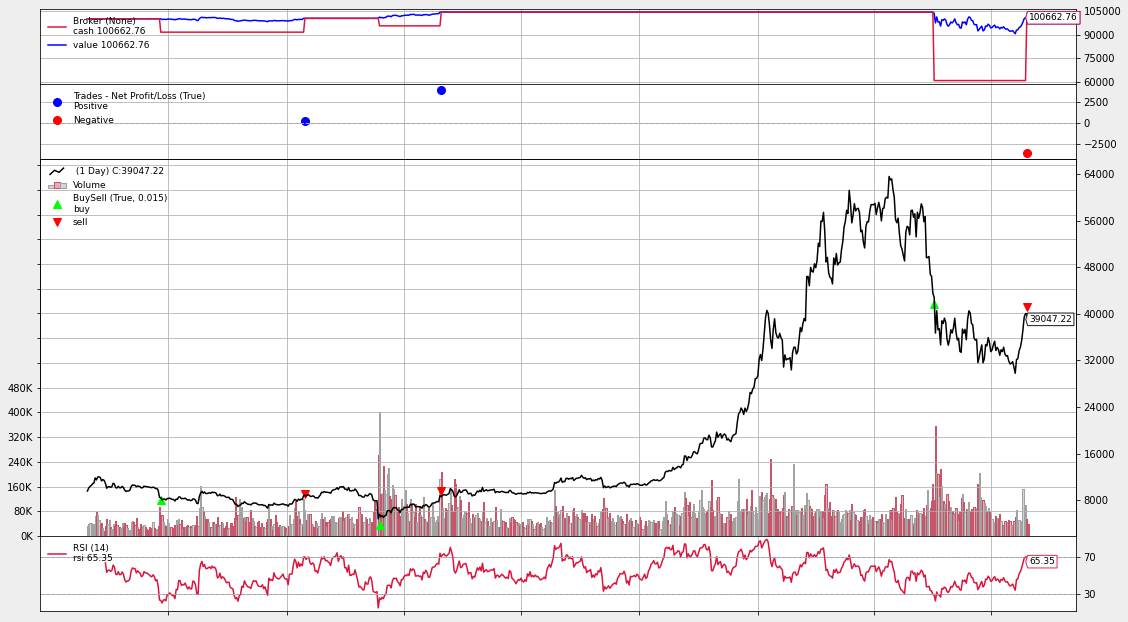

In [ ]:
app.run()